# Image Classification Implementation

In [1]:
!pip install split-folders
!pip install torchsampler

**Libraries**

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms 
import torchvision.models as models
from torchsampler import ImbalancedDatasetSampler

import splitfolders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
from warnings import filterwarnings as fws
fws('ignore')
%matplotlib inline

In [3]:
ROOT = '/kaggle/input/dataset/output_dataset_raw'

splitfolders.ratio(ROOT, output="output", seed=143, ratio=(.8, 0.1,0.1))

Copying files: 2183 files [00:20, 106.35 files/s]


# Display Sample Image

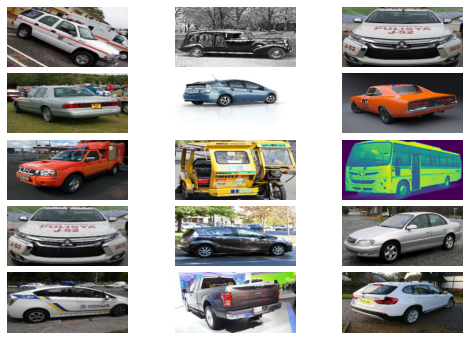

In [4]:
import cv2

split_flder_img_paths = []
split_directory = "/kaggle/working/output"
for folder in os.listdir(split_directory):
    split_folder = os.path.join(split_directory, folder)
    for class_ in os.listdir(split_folder):
        class_folder = os.path.join(split_folder, class_)
        for img in os.listdir(class_folder):
            split_flder_img_paths.append(os.path.join(class_folder, img))
            

def display_image(img_array, rows=5, cols=3):
    size = (500, 250)
    fig, axs = plt.subplots(rows, cols, figsize=(12, 6))
    idx = 0
    for i in range(rows):
        for j in range(cols):
            resized_image = cv2.resize(img_array[idx], size)
            axs[i,j].imshow(resized_image)
            axs[i, j].axis("off")
            idx += 1
    plt.subplots_adjust(wspace=-0.5, hspace=0.1)
    plt.show()
    
np.random.seed(143)

display_image([plt.imread(idx) for idx in np.random.choice(split_flder_img_paths, 50)])

# Prepare Dataset and DataLoaders

In [8]:
def set_seeds(seed=143):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_seeds()
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                       transforms.Resize((224,224)), 
                                       transforms.ToTensor(), 
                                       transforms.Normalize(mean=[0.4440, 0.4282, 0.4169], std=[0.2641, 0.2625, 0.2647])
                                      ])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.4567, 0.4337, 0.4254], std=[0.2616, 0.2599, 0.2638])
                                     ])

train_set = torchvision.datasets.ImageFolder("/kaggle/working/output/train", transform = train_transforms)
test_set = torchvision.datasets.ImageFolder("/kaggle/working/output/test", transform = test_transforms)
val_set = torchvision.datasets.ImageFolder("/kaggle/working/output/val", transform = test_transforms)

train_loader = torch.utils.data.DataLoader(train_set, sampler=ImbalancedDatasetSampler(train_set), batch_size=16)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False)

**Get pixel normalization measures**

In [ ]:
def get_measures(loader):
    mean = 0.0
    std = 0.0
    total_img_count = 0
    for images, _ in loader:
        image_batch_count = images.size(0)
        images = images.view(image_batch_count, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_img_count += image_batch_count
        
    mean /= total_img_count
    std /= total_img_count
    
    return mean, std

mean, std = get_measures(train_loader)
print(mean, std)

**Show dataloader batch sample**

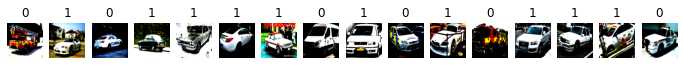

In [9]:
def show_batch(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.__next__()
    images = images.permute(0, 2, 3, 1)
    images = images.numpy()
    fig, axs = plt.subplots(1, len(images), figsize=(12, 2))
    for i in range(len(images)):
        axs[i].imshow(images[i], vmin=0, vmax=1)
        axs[i].axis('off')
        axs[i].set_title(labels[i].numpy())
    plt.show()
    
show_batch(train_loader)

# Training

In [10]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

# save best model per architecture
def train_nn(model, train_loader, val_loader, criterion, optimizer, n_epochs):
    set_seeds()
    start_time = time.perf_counter()
    
    device = set_device()
    best_acc = 0.0
    
    l_epoch_loss = []
    l_epoch_acc = []
    l_val_loss = []
    l_val_acc = []
    
    for epoch in range(n_epochs):
        print("Epoch number: %d" % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
            
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.0 * running_correct / total
        l_epoch_loss.append(epoch_loss)
        l_epoch_acc.append(epoch_acc)
        
        print("    - Training dataset got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
              % (running_correct, total, epoch_acc, epoch_loss))
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)        
        l_val_loss.append(val_loss)
        l_val_acc.append(val_acc)
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_{model._get_name()}.pth")
            print("    - New best model saved ✅.")
            
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print('-'*95)
    print(f"Execution time: {elapsed_time/60} minutes")
    return l_epoch_loss, l_epoch_acc, l_val_loss, l_val_acc

**Evaluate model function**

In [11]:
def evaluate_model(model, val_loader, criterion):
    device = set_device()
    model.eval()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
            
    val_loss = running_loss/len(val_loader)
    val_acc = 100.0 * running_correct / total
    
    print("    - Validation dataset got %d out of %d images correctly (%.3f%%). Validation loss: %.3f"
          % (running_correct, total, val_acc, val_loss))
    
    return val_loss, val_acc

# Instantiate Model and Configure Fully Connected Layer

In [12]:
def modify_fc(model, number_of_classes=2):
    if isinstance(model, nn.Module):
        if isinstance(model, nn.Sequential):
            # Modify the fc layer of a Sequential model
            model[-1] = nn.Linear(model[-1].in_features, number_of_classes)
        elif hasattr(model, "fc"):
            # Modify the fc layer of a model with an fc attribute (such as ResNet)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, number_of_classes)
        elif hasattr(model, "classifier"):
            # Modify the fc layer of a model with a classifier attribute (such as DenseNet, MobileNet, and VGGNet)
            if isinstance(model.classifier, nn.ModuleList):
                # Modify the fc layer of a model with a ModuleList classifier (such as VGGNet)
                num_ftrs = model.classifier[6].in_features
                model.classifier[6] = nn.Linear(num_ftrs, number_of_classes)
            elif isinstance(model.classifier, nn.Sequential):
                # Modify the fc layer of a model with a Sequential classifier (such as MobileNet and VGGNet)
                model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, number_of_classes)
            else:
                # Modify the fc layer of a model with a single linear layer classifier (such as DenseNet)
                num_ftrs = model.classifier.in_features
                model.classifier = nn.Linear(num_ftrs, number_of_classes)
        else:
            raise AttributeError("Model has no fc or classifier attribute")
    else:
        raise TypeError("Model is not a PyTorch module")
    device = set_device()
    return model.to(device)


resnet18 = models.resnet18(pretrained=False)
densenet = models.densenet161(pretrained=False)
vggnet = models.vgg16(pretrained=False)
mobilenet = models.mobilenet_v2(pretrained=False)

**Trainer**

In [13]:
# model, train_loader, val_loader, criterion, optimizer, n_epochs
def train(model, epochs=30):
    model = modify_fc(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    results = train_nn(
        model,
        train_loader, 
        val_loader,
        loss_fn, 
        optimizer, 
        epochs)
    
    return results

In [14]:
resnet_results = train(resnet18)

Epoch number: 1
    - Training dataset got 1041 out of 1746 images correctly (59.622%). Epoch loss: 0.716
    - Validation dataset got 143 out of 218 images correctly (65.596%). Validation loss: 0.615
    - New best model saved ✅.
Epoch number: 2
    - Training dataset got 1171 out of 1746 images correctly (67.068%). Epoch loss: 0.624
    - Validation dataset got 158 out of 218 images correctly (72.477%). Validation loss: 0.560
    - New best model saved ✅.
Epoch number: 3
    - Training dataset got 1229 out of 1746 images correctly (70.389%). Epoch loss: 0.578
    - Validation dataset got 148 out of 218 images correctly (67.890%). Validation loss: 0.770
Epoch number: 4
    - Training dataset got 1274 out of 1746 images correctly (72.967%). Epoch loss: 0.547
    - Validation dataset got 155 out of 218 images correctly (71.101%). Validation loss: 0.561
Epoch number: 5
    - Training dataset got 1282 out of 1746 images correctly (73.425%). Epoch loss: 0.537
    - Validation dataset got 1

In [15]:
densenet_results = train(densenet)

Epoch number: 1
    - Training dataset got 1035 out of 1746 images correctly (59.278%). Epoch loss: 0.714
    - Validation dataset got 148 out of 218 images correctly (67.890%). Validation loss: 0.641
    - New best model saved ✅.
Epoch number: 2
    - Training dataset got 1238 out of 1746 images correctly (70.905%). Epoch loss: 0.570
    - Validation dataset got 139 out of 218 images correctly (63.761%). Validation loss: 0.646
Epoch number: 3
    - Training dataset got 1231 out of 1746 images correctly (70.504%). Epoch loss: 0.604
    - Validation dataset got 138 out of 218 images correctly (63.303%). Validation loss: 0.832
Epoch number: 4
    - Training dataset got 1281 out of 1746 images correctly (73.368%). Epoch loss: 0.551
    - Validation dataset got 175 out of 218 images correctly (80.275%). Validation loss: 0.451
    - New best model saved ✅.
Epoch number: 5
    - Training dataset got 1332 out of 1746 images correctly (76.289%). Epoch loss: 0.525
    - Validation dataset got 1

In [16]:
vggnet_results = train(vggnet)

Epoch number: 1
    - Training dataset got 849 out of 1746 images correctly (48.625%). Epoch loss: 5.642
    - Validation dataset got 129 out of 218 images correctly (59.174%). Validation loss: 0.691
    - New best model saved ✅.
Epoch number: 2
    - Training dataset got 897 out of 1746 images correctly (51.375%). Epoch loss: 0.693
    - Validation dataset got 129 out of 218 images correctly (59.174%). Validation loss: 0.683
Epoch number: 3
    - Training dataset got 882 out of 1746 images correctly (50.515%). Epoch loss: 0.694
    - Validation dataset got 129 out of 218 images correctly (59.174%). Validation loss: 0.692
Epoch number: 4
    - Training dataset got 847 out of 1746 images correctly (48.511%). Epoch loss: 0.694
    - Validation dataset got 89 out of 218 images correctly (40.826%). Validation loss: 0.694
Epoch number: 5
    - Training dataset got 823 out of 1746 images correctly (47.136%). Epoch loss: 0.693
    - Validation dataset got 89 out of 218 images correctly (40.82

In [17]:
mobilenet_results = train(mobilenet)

Epoch number: 1
    - Training dataset got 1006 out of 1746 images correctly (57.617%). Epoch loss: 0.728
    - Validation dataset got 137 out of 218 images correctly (62.844%). Validation loss: 0.761
    - New best model saved ✅.
Epoch number: 2
    - Training dataset got 1271 out of 1746 images correctly (72.795%). Epoch loss: 0.540
    - Validation dataset got 119 out of 218 images correctly (54.587%). Validation loss: 0.932
Epoch number: 3
    - Training dataset got 1328 out of 1746 images correctly (76.060%). Epoch loss: 0.488
    - Validation dataset got 150 out of 218 images correctly (68.807%). Validation loss: 1.096
    - New best model saved ✅.
Epoch number: 4
    - Training dataset got 1406 out of 1746 images correctly (80.527%). Epoch loss: 0.456
    - Validation dataset got 168 out of 218 images correctly (77.064%). Validation loss: 0.495
    - New best model saved ✅.
Epoch number: 5
    - Training dataset got 1431 out of 1746 images correctly (81.959%). Epoch loss: 0.415


# Image Classification Results

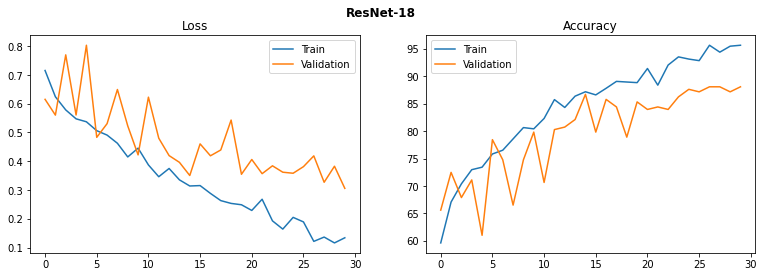

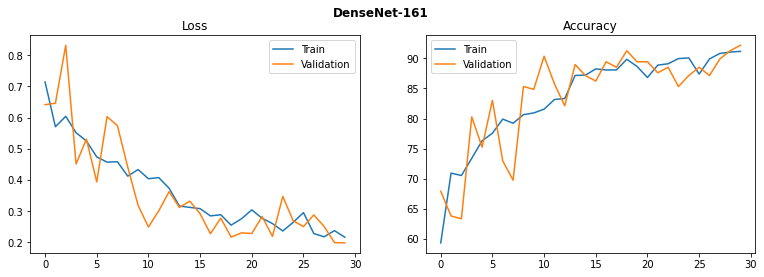

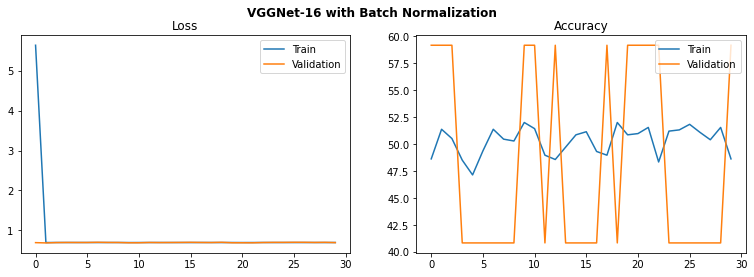

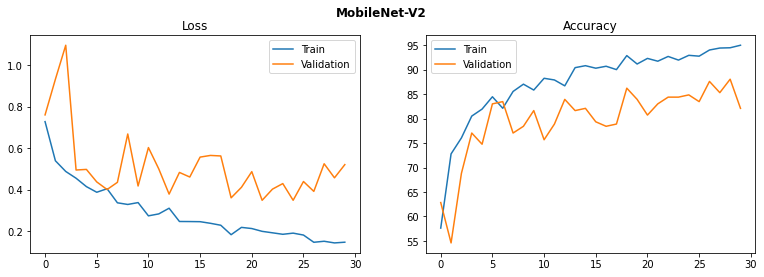

In [18]:
def visualize_results(data, title=None):
    fig, axs = plt.subplots(1,2, figsize=(13,4))
    set_title = ['Loss', 'Accuracy']
    i = 0
    for ax in axs:
        ax.plot(data[0+i], label='Train')
        ax.plot(data[2+i], label='Validation')
        ax.set_title(set_title[0+i])
        ax.legend()
        if title:
            fig.suptitle(title, fontweight='bold')
        i += 1
    plt.show()
    
visualize_results(resnet_results, 'ResNet-18')
visualize_results(densenet_results, 'DenseNet-161')
visualize_results(vggnet_results, 'VGGNet-16 with Batch Normalization')
visualize_results(mobilenet_results, 'MobileNet-V2')

# Model Evaluation

In [19]:
load_state_dict = lambda model, path: model.load_state_dict(torch.load(path))

display(load_state_dict(modify_fc(resnet18), "/kaggle/working/best_ResNet.pth"))
display(load_state_dict(modify_fc(densenet), "/kaggle/working/best_DenseNet.pth"))
display(load_state_dict(modify_fc(vggnet), "/kaggle/working/best_VGG.pth"))
display(load_state_dict(modify_fc(mobilenet), "/kaggle/working/best_MobileNetV2.pth"))

<All keys matched successfully>

<All keys matched successfully>

<All keys matched successfully>

<All keys matched successfully>

**Model Evaluation through Test Loader**

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns

sns.set_theme(rc={'figure.figsize':(9,6)})


def evaluate_model(model, test_loader):
    device = set_device()
    model.eval()
    true_labels = []
    pred_labels = []

    for input, target in test_loader:
        input = input.to(device)
        target = target.to(device)
        
        output = model(input)
        pred_labels.extend(output.argmax(dim=1).tolist())
        true_labels.extend(target.tolist())
        
    report = classification_report(true_labels, pred_labels)
    cm = confusion_matrix(true_labels, pred_labels)
    
    acc = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    
    print(f"{model._get_name()} Results")
    print(report)
    
    ax = sns.heatmap(cm, annot=True, fmt='d', cbar=False, square=True, cmap='Blues')
    ax.set_title('Predicted Values')
    ax.set_ylabel('True Values')
    ax.xaxis.set_ticks_position('top')
    plt.show()

    return acc, f1, precision, recall

# Classification Report and Confusion Matrix

ResNet Results
              precision    recall  f1-score   support

           0       0.76      0.82      0.79        90
           1       0.87      0.81      0.84       129

    accuracy                           0.82       219
   macro avg       0.81      0.82      0.81       219
weighted avg       0.82      0.82      0.82       219



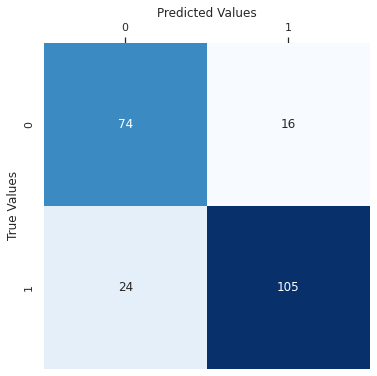

In [21]:
resnet_res = evaluate_model(resnet18, test_loader)

DenseNet Results
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        90
           1       0.87      0.88      0.88       129

    accuracy                           0.85       219
   macro avg       0.85      0.85      0.85       219
weighted avg       0.85      0.85      0.85       219



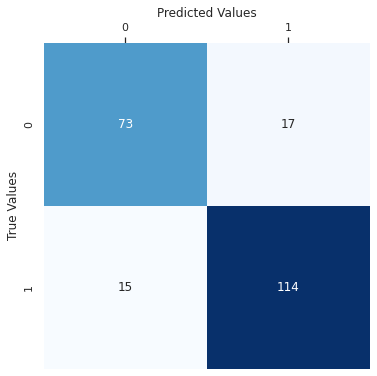

In [22]:
densenet_res = evaluate_model(densenet, test_loader)

VGG Results
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.59      1.00      0.74       129

    accuracy                           0.59       219
   macro avg       0.29      0.50      0.37       219
weighted avg       0.35      0.59      0.44       219



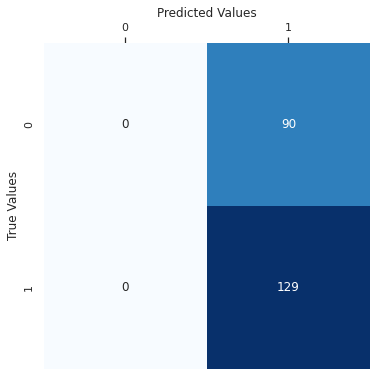

In [24]:
vggnet_res = evaluate_model(vggnet, test_loader)

MobileNetV2 Results
              precision    recall  f1-score   support

           0       0.85      0.64      0.73        90
           1       0.79      0.92      0.85       129

    accuracy                           0.81       219
   macro avg       0.82      0.78      0.79       219
weighted avg       0.81      0.81      0.80       219



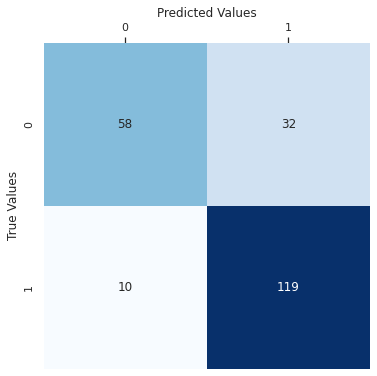

In [25]:
mobilenet_res = evaluate_model(mobilenet, test_loader)

### Model Performance Comparison

In [26]:
results = {'ResNet-18':list(resnet_res), 
           'DenseNet-161':list(densenet_res), 
           'VGGNet-16_BN':list(vggnet_res), 
           'MobileNet-v2':list(mobilenet_res)}

results_df = pd.DataFrame(results, index=['accuracy', 'f1 score', 'precision', 'recall'])
results_df

,ResNet-18,DenseNet-161,VGGNet-16_BN,MobileNet-v2
accuracy,0.817352,0.853881,0.589041,0.808219
f1 score,0.840000,0.876923,0.741379,0.850000
precision,0.867769,0.870229,0.589041,0.788079
recall,0.813953,0.883721,1.000000,0.922481


In [62]:
import plotly.graph_objects as go
dframe = results_df.T
metrics = dframe.columns

fig = go.Figure(data=[
    go.Bar(name=dframe.index[0], x=metrics, y=dframe.iloc[0,:].values, width=0.12),
    go.Bar(name=dframe.index[1], x=metrics, y=dframe.iloc[1,:].values, width=0.12),
    go.Bar(name=dframe.index[2], x=metrics, y=dframe.iloc[2,:].values, width=0.12),
    go.Bar(name=dframe.index[3], x=metrics, y=dframe.iloc[3,:].values, width=0.12)
])

fig.update_layout(barmode='group', 
                  title='Model Scores Per Metrics', 
                  legend=dict(title="Models", title_font=dict(size=15)))
fig.show()

| Model | Execution Time (minutes) | Epochs |
| --- | --- | --- |
| ResNet-18 | 6.911438106999996 | 30 |
| DenseNet-161 | 25.99469538391667 | 30 |
| VGGNet-16_BN | 18.142611950249997 | 30 |
| MobileNet-V2 | 6.976669625583332 | 30 |

# GradCAM Explainer

In [51]:
!pip install grad-cam
import copy
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

In [55]:
def gradcam_explain(model, path):
    target_layers = [model.features]
    rgb_img = Image.open(path).convert('RGB')
    rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
    input_tensor = torchvision.transforms.functional.to_tensor(rgb_img).unsqueeze(0).float()
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    grayscale_cam = cam(input_tensor=input_tensor)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    display(Image.fromarray(visualization, 'RGB'))

In [56]:
img_paths = {'emergency':[], 'non_emergency':[]}
test_path = '/kaggle/working/output/test'
for class_ in os.listdir(test_path):
    img_path = os.path.join(test_path, class_)
    for img in os.listdir(img_path):
        img_paths[class_].append(os.path.join(img_path, img))
        
df_dict = {'label':[], 'path':[]}

for i in img_paths.values():
    for j in i:
        if j.split('/')[5] == 'emergency':
            df_dict['label'].append(0)
            df_dict['path'].append(j)
        else:
            df_dict['label'].append(1)
            df_dict['path'].append(j)
            
test_df = pd.DataFrame(df_dict)
test_df.head()

,label,path
0,0,/kaggle/working/output/test/emergency/image_10...
1,0,/kaggle/working/output/test/emergency/kaggle_1...
2,0,/kaggle/working/output/test/emergency/kaggle_9...
3,0,/kaggle/working/output/test/emergency/kaggle_1...
4,0,/kaggle/working/output/test/emergency/kaggle_1...


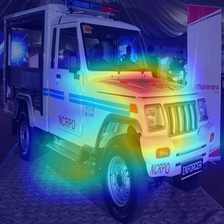

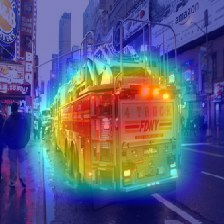

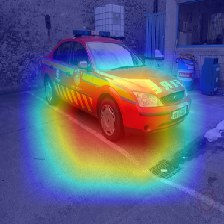

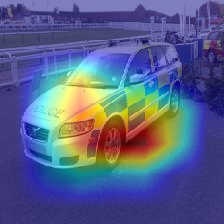

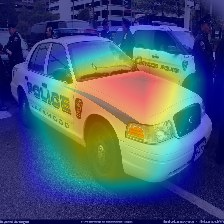

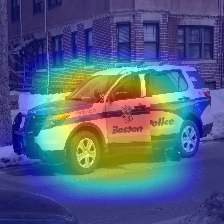

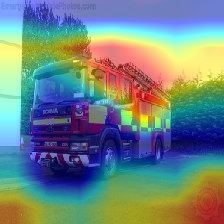

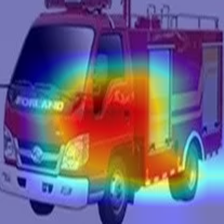

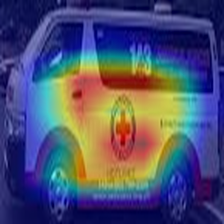

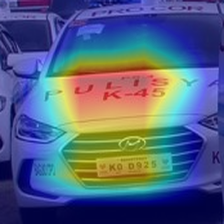

In [60]:
for i in test_df['path'][:10]:
    gradcam_explain(densenet, i)

In [61]:
training_results = {
    'resnet_results':[],
    'densenet_results':[],
    'vggnet_results':[],
    'mobilenet_results':[]
}
for k in training_results.keys():
    for i in eval(k):
        training_results[k].append(i)
        
pd.DataFrame(training_results).to_csv('training_results.csv', index=False)